In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

In [3]:
X,y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

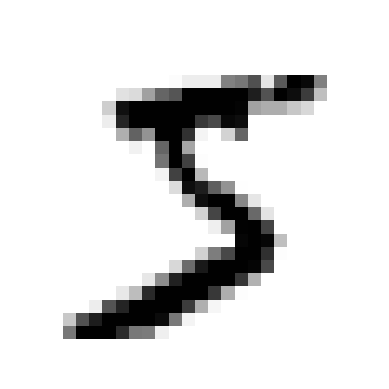

'4'

In [4]:
#images are in 28 by 28 array with intensity 0 to 255
import matplotlib.pyplot as plt

def plot_digits(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digits(some_digit)
plt.show()
y[2]

In [5]:
y[:20]

array(['5', '0', '4', '1', '9', '2', '1', '3', '1', '4', '3', '5', '3',
       '6', '1', '7', '2', '8', '6', '9'], dtype=object)

In [6]:
#its already split 60k train 10k test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
#Train a binary classifier 5 or not 5
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
#measuring cross val score
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [10]:
#instead of accuracy as it can be skewed for skewed datasets we use confusion matrix
#cross_val_predict returns the predictions not the accuracy
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [11]:
from sklearn.metrics import confusion_matrix, recall_score
cm = confusion_matrix(y_train_5, y_train_pred)
recall_score = recall_score(y_train_5, y_train_pred)
recall_score

0.6511713705958311

In [12]:
#f1 is harmonic mean of precision and reacall f1 is high if both are high
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [13]:
#decision_function() returns a score for each instance distance from decision boundary
#you can set your own threshold
y_scores = sgd_clf.decision_function([X[0]])
threshold = 0
y_some_digit_pred = (y_scores>threshold)
print(y_scores, y_some_digit_pred)

[2164.22030239] [ True]


If we raise the threshold to 3000 it will increase precision but decrease recall

In [14]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [15]:
#precision_recall_curve finction compute precisoin and recall for all possible 
#threshold last precision 0 and last recall =1 leading to infinity
from sklearn.metrics import precision_recall_curve

precisions, recalls, threshold = precision_recall_curve(y_train_5, y_scores)
print(precisions, recalls, threshold)

[0.09035    0.09035151 0.09035301 ... 1.         1.         1.        ] [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 3.68935621e-04
 1.84467810e-04 0.00000000e+00] [-146348.56726174 -142300.00705404 -137588.97581744 ...   38871.26391927
   42216.05562787   49441.43765905]


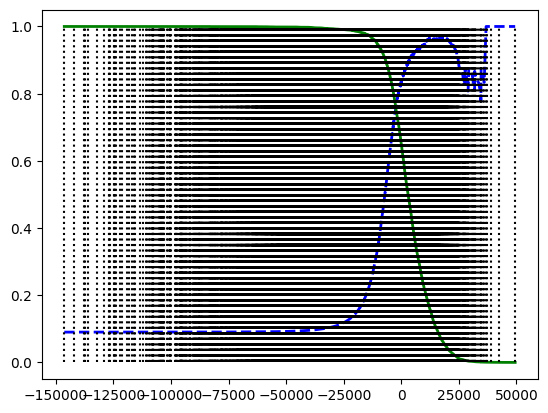

In [16]:
plt.plot(threshold, precisions[:-1], "b--", label="Precision",
linewidth=2)
plt.plot(threshold, recalls[:-1], "g-", label="Recall",
linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

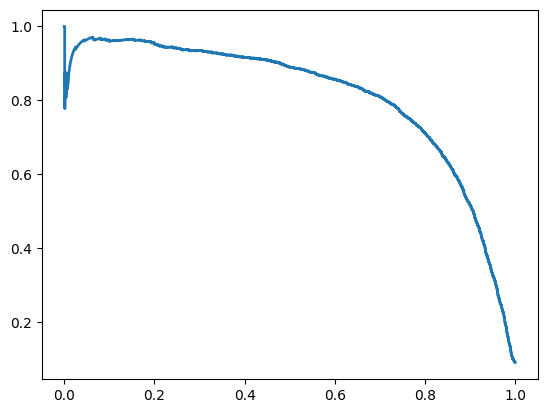

In [17]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.show

In [18]:
idx_for_90_precision = (precisions >= 0.90).argmax()
#argmax returns index where precision in precision array is more that 0.90
threshold_for_90_precision = threshold[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991441826)

In [19]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [20]:
from sklearn.metrics import precision_score
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [21]:
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

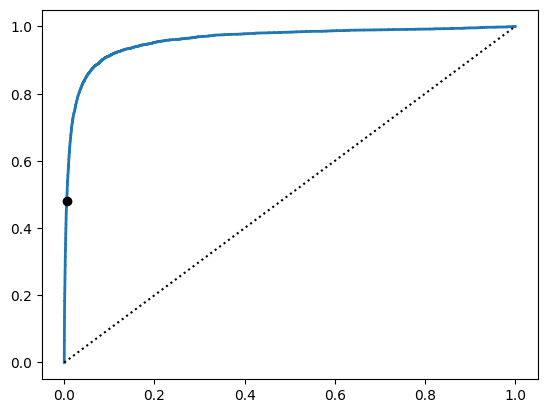

In [22]:
idx_for_threshold_at_90 = (threshold <=threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.show()

In [23]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [24]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

In [25]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_probas_forest[:5]

array([[0.11, 0.89],
       [0.98, 0.02],
       [0.96, 0.04],
       [1.  , 0.  ],
       [0.99, 0.01]])

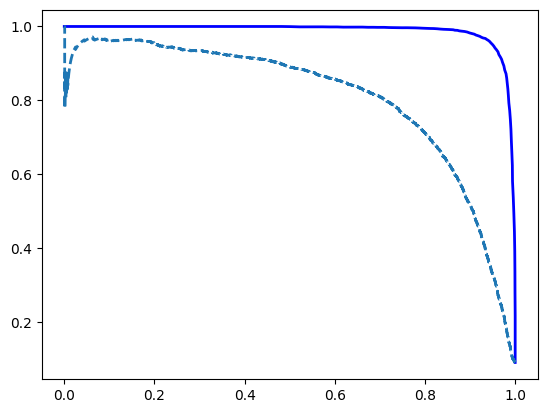

In [26]:
y_scores_forest = y_probas_forest[:,(1)]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
label="Random Forest")
plt.plot(recalls, precisions,
"--"
, linewidth=2, label="SGD")
plt.show()

In [27]:
#multiclass classification 
# ovr vs ovo
from sklearn.svm import SVC
svm_clf = SVC(random_state = 42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [28]:
svm_clf.predict([some_digit])
svm_clf_scores = svm_clf.decision_function([some_digit])
svm_clf_scores
#

array([[ 3.79297828,  0.72949369,  6.06184129,  8.29800527, -0.29383983,
         9.30157597,  1.74723215,  2.77365456,  7.20601456,  4.82245092]])

In [29]:
#class labels
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [30]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [31]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [32]:
#can use accuracy as roughly the same amount of image of each class
cross_val_score(ovr_clf, X_train, y_train, cv=3, scoring="accuracy")

KeyboardInterrupt: 

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

KeyboardInterrupt: 

In [ ]:
#multilabel clssification [1,2,4]
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7') # consists of 7 8 9
y_train_odd = (y_train.astype('int8')%2== 1) #checks wether odd or not
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
# it will predict two things first if more than 7 and second if odd or not
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")  #macro take individual f1 score of all then takes average

0.9778357403921755

In [ ]:
#if large model predicts true it gives 789 then its twice as likey to be odd than even to use that we will use chaining
from sklearn.multioutput import ClassifierChain
chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])
#it trains model on the order of multilabel results
chain_clf.predict([some_digit])

array([[0., 1.]])

In [ ]:
np.random.seed(42)
noise = np.random.randint(0,100,(len(X_train), 784)) #low,high,size
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784)) 
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test 

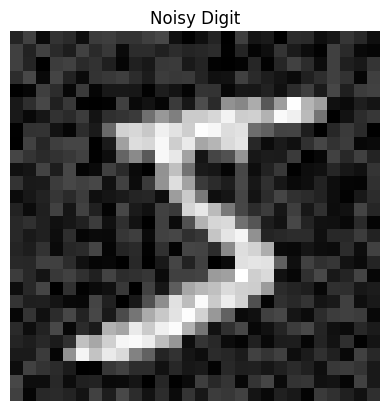

In [ ]:
import matplotlib.pyplot as plt
image = X_train_mod[0].reshape(28,28)
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.title("Noisy Digit")
plt.show()

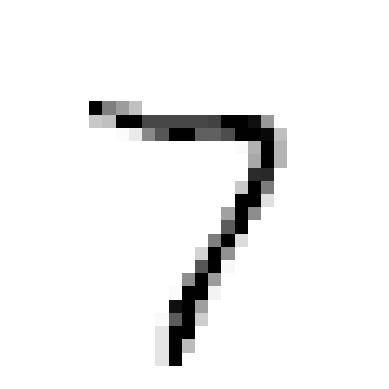

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digits(clean_digit)
plt.show()

In [ ]:
help(KNeighborsClassifier())

Help on KNeighborsClassifier in module sklearn.neighbors._classification object:

class KNeighborsClassifier(sklearn.neighbors._base.KNeighborsMixin, sklearn.base.ClassifierMixin, sklearn.neighbors._base.NeighborsBase)
 |  KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
 |  
 |  Classifier implementing the k-nearest neighbors vote.
 |  
 |  Read more in the :ref:`User Guide <classification>`.
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, default=5
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : {'uniform', 'distance'}, callable or None, default='uniform'
 |      Weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |        are weighted equally.
 |      - 'distance' : weight points by the inverse of their distance.
 |        in this case, closer neigh

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score


knn_clf = KNeighborsClassifier()

param_grid = {'n_neighbors' : [1,2,3,4,5,6,7,8,9,10], 'weights' : ['uniform', 'distance']}
rnd = RandomizedSearchCV(knn_clf, param_distributions=param_grid, cv=3, n_iter=3, scoring="accuracy")
rnd.fit(X_train, y_train)
best_clf = rnd.best_estimator_
y_preds = best_clf.predict(X_test) 
accuracy = accuracy_score(y_preds, y_test)
accuracy
#Standard scaling can be used to increase accuracy 

0.9706

In [ ]:
rnd.best_params_

{'weights': 'uniform', 'n_neighbors': 3}

Whenever using X_train and X_test if you have transformed x_train using fit_transform you have to use only transform
in X_test that is because when doing fit it learns std deviation and mean and then applies x-mean/std this should be applied in test set. If we did fit in test set then it would PEEK into the test set and this should be avoided as the model may learn about the test set It should remain unseen. so it should apply same transformation on the test set with 
only transform() not fit_transform()

In [35]:
#function to shift MNIST image left right up down and add that to dataset called data augmentation
def shift_image(img, direction):
    shifted = np.roll(img, shift=1 if direction in ['down', 'right'] else -1, axis=0 if direction in ['up', 'left'] else 1 )
    if direction == "up" : shifted[-1, :] = 0
    if direction == "down": shifted[1, :] = 0  
    if direction == "left": shifted[:, 1] = 0
    


(60000, 784)